<a href="https://colab.research.google.com/github/michaelawe01/Bournemouth-Uni-Data-Science-/blob/main/Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importation of basic libraries. other libraries will be imported further down in this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
import joblib  # For saving and loading models
from math import sqrt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score
import warnings

# Data importation and processing

In [ ]:
#data importation and processing

creepdf = pd.read_csv('creepdata1.csv')
creepdf = creepdf.dropna(subset=['tR', 'EL(%)', 'RA(%)', 'Stress (Mpa)'], how='any')
creepdf = creepdf.reset_index(drop=True)

# Define the columns that need imputation
columns_to_impute = ['Mn', 'Ni', 'Mo', 'Ti', 'Cu', 'Al', 'Co', 'Nb+Ta', 'Fe']

# Replace 'tr' and 'bal' with NaN for easier imputation
creepdf.replace({'tr': pd.NA, 'bal': pd.NA}, inplace=True)

# Convert the columns to numeric (if they are not already numeric)
creepdf[columns_to_impute] = creepdf[columns_to_impute].apply(pd.to_numeric, errors='coerce')

# Use pandas interpolate method for linear interpolation
creepdf[columns_to_impute] = creepdf[columns_to_impute].interpolate(method='linear', axis=0)


# determine the tR distribution and reduction rate
creepdf['%Reduction_rate'] = creepdf['RA(%)'] / creepdf['tR']
creepdf['tR-Distr'] = None

def classify_tR_dist(tR):
  if tR <= 55000:
    return "less_T"
  else:
    return "greater_T"

creepdf['tR-Distr'] = creepdf['tR'].apply(classify_tR_dist)

def classify_reduction_rate(value):
    if value < 0.001:
        return "strong"
    elif 0.001 <= value < 0.1:
        return "ok"
    else:
        return "weak"

creepdf['rate_class'] = creepdf['%Reduction_rate'].apply(classify_reduction_rate)

creepdf = creepdf[~creepdf.duplicated()]

#this is to harmonize all variables such that there are no duplicated variables and all unnecessary spacing are stripped
creepdf['metalworking process 2'] = creepdf['metalworking process 2'].str.lower().replace('cold drawn', 'cold drawn')
creepdf['pf'] = creepdf['pf'].str.lower().replace(['test piece', 'block'], ['Test piece', 'Block'])
creepdf['Treatment type 1'] = creepdf['Treatment type 1'].str.lower().replace('solution treated', 'Solution treated')
creepdf['metalworking process 1'] = creepdf['metalworking process 1'].str.lower().replace('forged', 'Forged')

columns = ['Reference code','MT','Top','Dp','pf', 'Casting','type of mold','Treatment type 1','metalworking process 1','metalworking process 2']
for column in columns:
    creepdf[column] = creepdf[column].str.strip()

# Fill NaN values in specific columns with appropriate replacements
fill_values = {
    'Dp': "no process",
    'Soi': "0",
    'Top': "nmp",  # No melting process
    'pf': "nrf",   # No recorded form
    'Tk': "0",
    'W.1': "0",
    'L': "0",
    'OD (mm)': "0",
    'Wt (mm)': "0",
    'L (mm)': "0",
    'Agsn': "0",
    'Nmi': "0",
    'inoculation': "no"
}

# Use `fillna` and reassign to creepdf
creepdf = creepdf.fillna(value=fill_values)
columns_to_drop = ['%Reduction_rate' ]
creepdf.drop(columns_to_drop, axis=1)

,Reference code,MT,C,Si,Mn,P,S,Ni,Cr,Mo,...,Agsn,Rh,Nmi,Temp,Stress (Mpa),tR,EL(%),RA(%),tR-Distr,rate_class
0,STB 410 (0.2C)_CAC,Carbon steels,0.20,0.29,0.55,0.021,0.009,0.000,0.054,0.012,...,6.8,74,0.11,450.0,265.0,199978.00,46.0,70.0,greater_T,strong
1,STB 410 (0.2C)_CAG,Carbon steels,0.21,0.21,0.62,0.014,0.014,0.000,0.046,0.019,...,6.0,75,0.11,450.0,265.0,199345.00,40.0,68.0,greater_T,strong
2,STB 410 (0.2C)_CAH,Carbon steels,0.24,0.24,0.64,0.015,0.013,0.000,0.074,0.019,...,7.9,78,0.12,450.0,265.0,196440.00,42.0,68.0,greater_T,strong
3,STB 410 (0.2C)_CAJ,Carbon steels,0.20,0.20,0.47,0.007,0.009,0.000,0.056,0.010,...,7.0,75,0.1,450.0,265.0,196440.00,26.0,52.0,greater_T,strong
4,STB 410 (0.2C)_CAA,Carbon steels,0.20,0.31,0.59,0.018,0.009,0.000,0.046,0.011,...,6.4,74,0.16,450.0,196.0,195221.60,35.0,76.0,greater_T,strong
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3818,STBA 22(1Cr-0.5Mo)_MBB,Low alloy steels,0.12,0.36,0.52,0.009,0.003,0.089,0.970,0.610,...,7.0,83,0.08,550.0,108.0,0.40,28.0,55.0,less_T,weak
3819,STBA 22(1Cr-0.5Mo)_MBC,Low alloy steels,0.09,0.37,0.49,0.006,0.005,0.055,0.980,0.570,...,7.5,79,0.1,550.0,108.0,0.10,35.0,42.0,less_T,weak
3820,STBA 22(1Cr-0.5Mo)_MBD,Low alloy steels,0.10,0.28,0.49,0.008,0.009,0.028,0.900,0.560,...,6.0,77,0.13,550.0,108.0,0.10,35.0,54.0,less_T,weak
3821,STBA 22(1Cr-0.5Mo)_MBE,Low alloy steels,0.12,0.43,0.48,0.014,0.008,0.051,0.960,0.560,...,6.5,81,0.07,550.0,108.0,0.10,26.0,30.0,less_T,weak


In [ ]:
#data pre-processing label econder and scaling


steel_creepdf = creepdf.copy()

# Encode all categorical columns using Label Encoder
label_encoder = LabelEncoder()
categorical_columns = ['MT', 'Top', 'Dp', 'pf', 'Casting', 'type of mold', 'Treatment type 1',
                       'metalworking process 1', 'metalworking process 2', 'AC', 'WBC', 'BC',
                       'WQ', 'ArC', 'FC', 'OQ', 'rate_class', 'tR-Distr', 'inoculation']

for column in categorical_columns:
    steel_creepdf[column] = label_encoder.fit_transform(steel_creepdf[column])


# Scalling
numerical = ['C','Si', 'Mn', 'P','S', 'Ni', 'Cr', 'Mo', 'W', 'Ti', 'B', 'Cu', 'V', 'Al', 'N',
             'Nb', 'Ta', 'Zr', 'Co', 'Ceq', 'Nb+Ta', 'Fe', 'O', 'Ca', 'As', 'Sb', 'Sn', 'La',
             'Ce','Soi', 'Tk', 'W.1', 'L', 'OD (mm)', 'Wt (mm)', 'L (mm)', 'Part 1 temp(deg)',
             'Part 1 time(h)', 'part 2 temp(deg)','Part 2 time(h)', 'part 3 temp(deg)',
             'part 3 time(h)', 'part 4 temp(deg)', 'part 4 time(h)', 'part 5 temp(deg)',
             'part 5 time(h)', 'Agsn', 'Rh', 'Nmi', 'Temp', 'Stress (Mpa)', 'EL(%)', 'RA(%)' ]

scaler = MinMaxScaler()
steel_creepdf[numerical] = scaler.fit_transform(steel_creepdf[numerical])


# Assuming steel_creepdf is your DataFrame
for column in steel_creepdf.columns:
    if steel_creepdf[column].dtype == bool:
        steel_creepdf[column] = steel_creepdf[column].astype(int)


## Stratified data exclusion

In [ ]:

# Define bin edges for stratification
bin_edges = np.arange(0, 201000, 10000)  # 0 to 200k in 10k intervals

# Create a new column for stratification bins
steel_creepdf['tR_bin'] = pd.cut(steel_creepdf['tR'], bins=bin_edges, labels=False, include_lowest=True)

# Perform stratified sampling
stratified_data, main_data = train_test_split(
    steel_creepdf,
    test_size=0.9,
    stratify=steel_creepdf['tR_bin'],
    random_state=42
)

# Drop the temporary tR_bin column from both datasets
stratified_data = stratified_data.drop(columns=['tR_bin'])
main_data = main_data.drop(columns=['tR_bin'])


main_data = main_data.reset_index(drop=True)
stratified_data = stratified_data.reset_index(drop=True)
steel_creepdf = main_data.copy()


# 01 Time-to-rupture tR Training
1.   Training: tR threshold greater 55-95k
2.   Training: tR threshold less 55-95k

# 02 classification Training 3: tr-distribution training

1.   Uses all samples in the datasets






Processing dataset: tshld_55k_greater
  Decision Tree MSE: 1096003.4483
  XGBoost MSE: 1014989.6092
  New best model saved from dataset: tshld_55k_greater with MSE: 1014989.6092


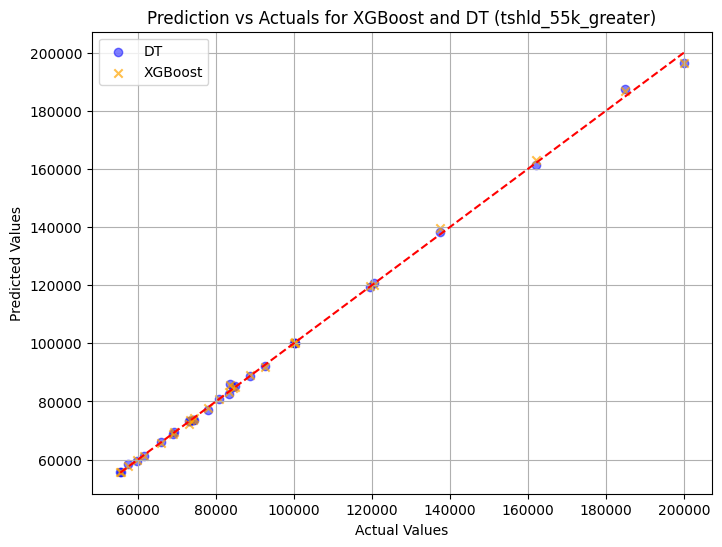

Processing dataset: tshld_65k_greater
  Decision Tree MSE: 12021706.2073
  XGBoost MSE: 14798981.3497
Processing dataset: tshld_75k_greater
  Decision Tree MSE: 895213295.9494
  XGBoost MSE: 894839318.5851
Processing dataset: tshld_85k_greater
  Decision Tree MSE: 17174498.7443
  XGBoost MSE: 1140580.1417
Processing dataset: tshld_95k_greater
  Decision Tree MSE: 14382909.1711
  XGBoost MSE: 2462455.8496

Best Model Summary:
  Dataset: tshld_55k_greater
  MSE: 1014989.6092
  Model saved to: best_model_greater.pkl


In [ ]:
#Training 1: tR threshold greater than 55000
tshld_55k_greater = steel_creepdf[steel_creepdf['tR'] >= 55000].reset_index(drop=True)
tshld_65k_greater = steel_creepdf[steel_creepdf['tR'] >= 65000].reset_index(drop=True)
tshld_75k_greater = steel_creepdf[steel_creepdf['tR'] >= 75000].reset_index(drop=True)
tshld_85k_greater = steel_creepdf[steel_creepdf['tR'] >= 85000].reset_index(drop=True)
tshld_95k_greater = steel_creepdf[steel_creepdf['tR'] >= 95000].reset_index(drop=True)

datasets = {
    "tshld_55k_greater": tshld_55k_greater,
    "tshld_65k_greater": tshld_65k_greater,
    "tshld_75k_greater": tshld_75k_greater,
    "tshld_85k_greater": tshld_85k_greater,
    "tshld_95k_greater": tshld_95k_greater,
}

# Initialize variables to track the best model
best_model = None
best_model_name = None
lowest_mse = float("inf")
best_model_path = "best_model_greater.pkl"

# Iterate over each dataset
for name, data in datasets.items():
    print(f"Processing dataset: {name}")

    # Target and features
    X = data.drop(columns=["tR", "Reference code", 'EL(%)', 'RA(%)', '%Reduction_rate', 'rate_class', 'tR-Distr', 'MT'])
    y = data["tR"]

    # Handle missing values
    X.fillna(X.mean(), inplace=True)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    # Train Decision Tree model
    dt_model = DecisionTreeRegressor(random_state=42)
    dt_model.fit(X_train, y_train)
    dt_predictions = dt_model.predict(X_test)
    dt_mse = mean_squared_error(y_test, dt_predictions)
    print(f"  Decision Tree MSE: {dt_mse:.4f}")

    # Train XGBoost model
    xgb_model = XGBRegressor(random_state=42)
    xgb_model.fit(X_train, y_train)
    xgb_predictions = xgb_model.predict(X_test)
    xgb_mse = mean_squared_error(y_test, xgb_predictions)
    print(f"  XGBoost MSE: {xgb_mse:.4f}")

    # Check if the XGBoost model is the best so far
    if xgb_mse < lowest_mse:
        lowest_mse = xgb_mse
        best_model = xgb_model
        best_model_name = name

        # Save the best model
        joblib.dump(best_model, best_model_path)
        print(f"  New best model saved from dataset: {name} with MSE: {lowest_mse:.4f}")



        # Plot the predictions for both models
        plt.figure(figsize=(8, 6))

        # Plot for Decision Tree
        plt.scatter(y_test, dt_predictions, label="DT", alpha=0.5, color="blue")

        # Plot for XGBoost
        plt.scatter(y_test, xgb_predictions, label="XGBoost", alpha=0.7, color="orange", marker='x')

        # Ideal prediction line
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')

        # Labels, title, and legend
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.title(f"Prediction vs Actuals for XGBoost and DT ({name})")
        plt.legend()
        plt.grid(True)
        plt.show()

# Print summary of the best model
print("\nBest Model Summary:")
print(f"  Dataset: {best_model_name}")
print(f"  MSE: {lowest_mse:.4f}")
print(f"  Model saved to: {best_model_path}")



Processing dataset: tshld_55k_less
  Decision Tree MSE: 28643.4468
  XGBoost MSE: 14533.2760
  New best model saved from dataset: tshld_55k_less with MSE: 14533.2760


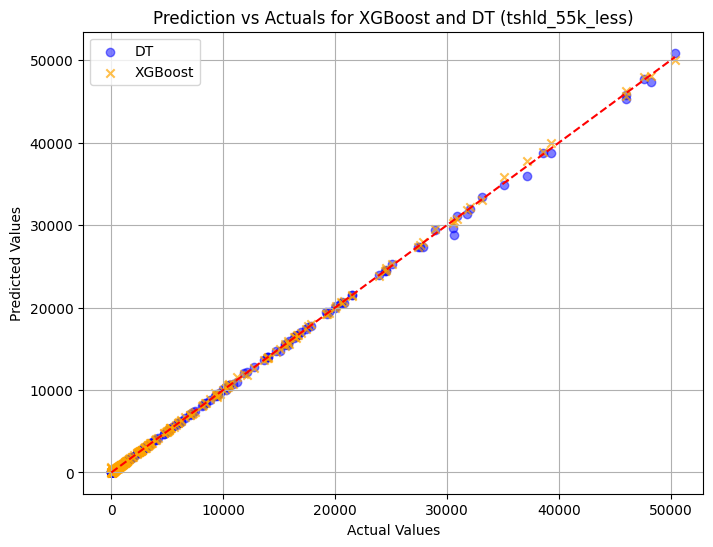

Processing dataset: tshld_65k_less
  Decision Tree MSE: 76893.5835
  XGBoost MSE: 22501.6590
Processing dataset: tshld_75k_less
  Decision Tree MSE: 60374.5210
  XGBoost MSE: 21379.9168
Processing dataset: tshld_85k_less
  Decision Tree MSE: 165260.7626
  XGBoost MSE: 21525.5327
Processing dataset: tshld_95k_less
  Decision Tree MSE: 49883.0434
  XGBoost MSE: 18584.3020

Best Model Summary:
  Dataset: tshld_55k_less
  MSE: 14533.2760
  Model saved to: best_model_less.pkl


In [ ]:

from sklearn.model_selection import cross_val_score, KFold
# Create datasets for different thresholds
tshld_55k_less = steel_creepdf[(steel_creepdf['tR'] < 55000) & (steel_creepdf['tR'] > 0)].reset_index(drop=True)
tshld_65k_less = steel_creepdf[(steel_creepdf['tR'] < 65000) & (steel_creepdf['tR'] > 0)].reset_index(drop=True)
tshld_75k_less = steel_creepdf[(steel_creepdf['tR'] < 75000) & (steel_creepdf['tR'] > 0)].reset_index(drop=True)
tshld_85k_less = steel_creepdf[(steel_creepdf['tR'] < 85000) & (steel_creepdf['tR'] > 0)].reset_index(drop=True)
tshld_95k_less = steel_creepdf[(steel_creepdf['tR'] < 95000) & (steel_creepdf['tR'] > 0)].reset_index(drop=True)

# Create a dictionary of datasets
datasets = {
    "tshld_55k_less": tshld_55k_less,
    "tshld_65k_less": tshld_65k_less,
    "tshld_75k_less": tshld_75k_less,
    "tshld_85k_less": tshld_85k_less,
    "tshld_95k_less": tshld_95k_less,
}

# Initialize variables to track the best model
best_model = None
best_model_name = None
lowest_mse = float("inf")
best_model_path = "best_model_less.pkl"

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Iterate over each dataset
for name, data in datasets.items():
    print(f"Processing dataset: {name}")

    # Target and features
    X = data.drop(columns=["tR", "Reference code", 'EL(%)', 'RA(%)', '%Reduction_rate', 'rate_class', 'tR-Distr', 'MT'])
    y = data["tR"]

    # Handle missing values
    X.fillna(X.mean(), inplace=True)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


    # Train Decision Tree model
    dt_model = DecisionTreeRegressor(random_state=42)
    dt_model.fit(X_train, y_train)
    dt_predictions = dt_model.predict(X_test)
    dt_mse = mean_squared_error(y_test, dt_predictions)
    print(f"  Decision Tree MSE: {dt_mse:.4f}")

    # Train XGBoost model
    xgb_model = XGBRegressor(random_state=42)
    xgb_model.fit(X_train, y_train)
    xgb_predictions = xgb_model.predict(X_test)
    xgb_mse = mean_squared_error(y_test, xgb_predictions)
    print(f"  XGBoost MSE: {xgb_mse:.4f}")

    # Check if the XGBoost model is the best so far
    if xgb_mse < lowest_mse:
        lowest_mse = xgb_mse
        best_model = xgb_model
        best_model_name = name

        # Save the best model
        joblib.dump(best_model, best_model_path)
        print(f"  New best model saved from dataset: {name} with MSE: {lowest_mse:.4f}")

        # Plot the predictions for both models
        plt.figure(figsize=(8, 6))

        # Plot for Decision Tree
        plt.scatter(y_test, dt_predictions, label="DT", alpha=0.5, color="blue")

        # Plot for XGBoost
        plt.scatter(y_test, xgb_predictions, label="XGBoost", alpha=0.7, color="orange", marker='x')

        # Ideal prediction line
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')

        # Labels, title, and legend
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.title(f"Prediction vs Actuals for XGBoost and DT ({name})")
        plt.legend()
        plt.grid(True)
        plt.show()

# Print summary of the best model
print("\nBest Model Summary:")
print(f"  Dataset: {best_model_name}")
print(f"  MSE: {lowest_mse:.4f}")
print(f"  Model saved to: {best_model_path}")


# Classification Training


1.   uses all samples in steel_creepdf




In [ ]:
#Training 3: tr-dsitribution training

warnings.filterwarnings("ignore")

# Partioning the data
X = steel_creepdf.drop(['tR-Distr', 'tR', 'EL(%)', 'RA(%)', '%Reduction_rate', 'rate_class', 'MT', 'Reference code'], axis=1)
y = steel_creepdf[['tR-Distr']]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize models
models = {}

# Models with default parameters
models['RandomForest'] = DecisionTreeClassifier()
models['KNN'] = KNeighborsClassifier()

# Cross-validation
best_model = None
best_score = 0

for model_name in models:
    model = models[model_name]
    # Perform cross-validation with resampled data
    results = cross_validate(
        model,
        X_train_resampled, y_train_resampled,
        cv=5,
        scoring=['accuracy', 'f1_macro', 'f1_weighted'],
        return_train_score=True
    )

    print(model_name + ":")
    print("Accuracy:", 'train:', results['train_accuracy'].mean(), '| test:', results['test_accuracy'].mean())
    print("Macro F1-score:", 'train:', results['train_f1_macro'].mean(), '| test:', results['test_f1_macro'].mean())
    print("Weighted F1-score:", 'train:', results['train_f1_weighted'].mean(), '| test:', results['test_f1_weighted'].mean())
    print("---------------------------------------------------------")

    # Save the model with the best test accuracy
    if results['test_accuracy'].mean() > best_score:
        best_score = results['test_accuracy'].mean()
        best_model = model

# Train the best model on the entire training data
if best_model is not None:
    best_model.fit(X_train_resampled, y_train_resampled)
    # Save the best model to a file
    joblib.dump(best_model, 'best_model.pkl')
    print("Best model saved as 'best_model.pkl'.")


RandomForest:
Accuracy: train: 1.0 | test: 0.9986158188777207
Macro F1-score: train: 1.0 | test: 0.998615812119154
Weighted F1-score: train: 1.0 | test: 0.9986158128933275
---------------------------------------------------------
KNN:
Accuracy: train: 0.9986155014249924 | test: 0.998615427921324
Macro F1-score: train: 0.9986154986443904 | test: 0.9986154230832982
Weighted F1-score: train: 0.9986154987108717 | test: 0.9986154242445652
---------------------------------------------------------
Best model saved as 'best_model.pkl'.


# Inference (Model testing)

In [ ]:
# Read the Excel file using pandas

test_creepdfc = pd.read_csv('test_creepdata111.csv')
test_creepdf = test_creepdfc.copy()
test_creepdf.drop('tR', axis=1, inplace=True)
test_creepdf.head()


,C,Si,Mn,P,S,Ni,Cr,Mo,W,Ti,...,WQ,ArC,FC,OQ,inoculation,Agsn,Rh,Nmi,Temp,Stress (Mpa)
0,0.20,0.29,0.55,0.021,0.009,0.00,0.054,0.012,0.0,0.0,...,No,No,No,No,NaN,6.8,74,0.11,450,265
1,0.20,0.31,0.59,0.018,0.009,0.00,0.046,0.011,0.0,0.0,...,No,No,No,No,NaN,6.4,74,0.16,450,137
2,0.23,0.32,0.53,0.023,0.016,0.00,0.016,0.005,0.0,0.0,...,No,No,No,No,NaN,6.3,74,0.19,450,88
3,0.24,0.24,0.64,0.015,0.013,0.00,0.074,0.019,0.0,0.0,...,No,No,No,No,NaN,7.9,78,0.12,500,157
4,0.29,0.20,0.93,0.014,0.015,0.03,0.030,0.360,0.0,0.0,...,No,No,Yes,No,NaN,6.7,81,0.05,500,157


In [ ]:
# Encode all categorical columns using Label Encoder
label_encoder = LabelEncoder()
categorical_columns = ['Top', 'Dp', 'pf', 'Casting', 'type of mold', 'Treatment type 1',
                       'metalworking process 1', 'metalworking process 2', 'AC', 'WBC', 'BC',
                       'WQ', 'ArC', 'FC', 'OQ', 'inoculation']

for column in categorical_columns:
    test_creepdf[column] = label_encoder.fit_transform(test_creepdf[column])

test_creepdf.head()

,C,Si,Mn,P,S,Ni,Cr,Mo,W,Ti,...,WQ,ArC,FC,OQ,inoculation,Agsn,Rh,Nmi,Temp,Stress (Mpa)
0,0.20,0.29,0.55,0.021,0.009,0.00,0.054,0.012,0.0,0.0,...,0,0,0,0,0,6.8,74,0.11,450,265
1,0.20,0.31,0.59,0.018,0.009,0.00,0.046,0.011,0.0,0.0,...,0,0,0,0,0,6.4,74,0.16,450,137
2,0.23,0.32,0.53,0.023,0.016,0.00,0.016,0.005,0.0,0.0,...,0,0,0,0,0,6.3,74,0.19,450,88
3,0.24,0.24,0.64,0.015,0.013,0.00,0.074,0.019,0.0,0.0,...,0,0,0,0,0,7.9,78,0.12,500,157
4,0.29,0.20,0.93,0.014,0.015,0.03,0.030,0.360,0.0,0.0,...,0,0,1,0,0,6.7,81,0.05,500,157


In [ ]:
# Scalling
scaler = MinMaxScaler()
test_creepdf = scaler.fit_transform(test_creepdf)

test_creepdf

array([[0.36111111, 0.15254237, 0.11111111, ..., 0.42857143, 0.        ,
        0.608     ],
       [0.36111111, 0.18644068, 0.14814815, ..., 0.66666667, 0.        ,
        0.26666667],
       [0.44444444, 0.20338983, 0.09259259, ..., 0.80952381, 0.        ,
        0.136     ],
       ...,
       [1.        , 0.28813559, 0.77777778, ...,        nan, 0.83333333,
        0.608     ],
       [1.        , 0.45762712, 1.        , ...,        nan, 0.83333333,
        0.608     ],
       [0.13888889, 0.13559322, 0.00925926, ..., 0.47619048, 0.33333333,
        0.18933333]])

In [ ]:
# model to predict distribution either grater than threshold or less than threshold

loaded_model = joblib.load('best_model.pkl')

def predict_inputs(test_creepdf):
    """
    Predict the output for a DataFrame of input features.
    Args:
        features_df (pandas.DataFrame): DataFrame of input features.
    Returns:
        pandas.Series: Predicted values for each instance.
    """
    try:
        predictions = loaded_model.predict(test_creepdf)  # Predict on DataFrame
        return pd.Series(predictions, index=test_creepdf.index)  # Return as Series
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None

# Assuming 'qtest_df' is a pandas DataFrame containing input features
qtest_df = pd.DataFrame(test_creepdf)  # Convert qtest (list or array-like) to DataFrame
predicted_outputs = predict_inputs(qtest_df)
print(f"Predicted Outputs:\n{predicted_outputs}")

Predicted Outputs:
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     1
10    0
11    0
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    1
27    1
28    1
29    1
30    1
31    1
32    1
33    1
34    1
35    1
36    1
37    1
dtype: int64


In [ ]:
# model to predict tR value for each test sample.

def load_model(predicted_output):
    """Load the appropriate model based on the predicted output."""
    try:
        if predicted_output == 0:
            return joblib.load('rf_model.pkl')
        else:
            return joblib.load('xgb_model.pkl')
    except Exception as e:
        raise RuntimeError(f"Error loading model: {e}")

def predict_tR(features, model):
    """Predict the output for a single input feature set."""
    try:
        prediction = model.predict([features])
        return prediction[0]
    except Exception as e:
        raise RuntimeError(f"Error during prediction: {e}")

# Assuming 'predicted_outputs' is a pandas Series containing predicted outputs
# from the previous step
def predict_all_tR(qtest_df, predicted_outputs):
    """Predict tR for all instances in ztest_df using appropriate models."""
    results = []
    for index, predicted_output in predicted_outputs.items():
        loaded_model = load_model(predicted_output)
        features = qtest_df.loc[index].values.tolist()  # Get features for current instance
        result = predict_tR(features, loaded_model)
        results.append(result)
    return pd.Series(results, index=predicted_outputs.index)

# Example usage for prediction
# Assuming 'ztest_df' is a pandas DataFrame containing input features
# and 'predicted_outputs' is a pandas Series from the previous step
#qtest_df = pd.DataFrame(qtest_df)  # Convert ztest to DataFrame if needed
all_tR_predictions = predict_all_tR(qtest_df, predicted_outputs)


In [ ]:
predictions_df = pd.DataFrame(all_tR_predictions, columns=['Predicted_tR'])
#predictions_df = predictions_df.reset_index(drop=True)
#test_creepdfc = test_creepdfc.reset_index(drop=True)
comparison_df = pd.concat([test_creepdfc['tR'], predictions_df['Predicted_tR']], axis=1)
comparison_df.head()

,tR,Predicted_tR
0,199978.0,45012.447
1,157720.7,41004.237
2,121857.4,40561.058
3,102448.2,35916.790
4,85699.2,45133.042
